[Chapter 2] Denoising and Detoning

In [105]:
import numpy as np
import pandas as pd

from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize

import matplotlib.pyplot as plt

The marcenko-pastur theorem

<Axes: >

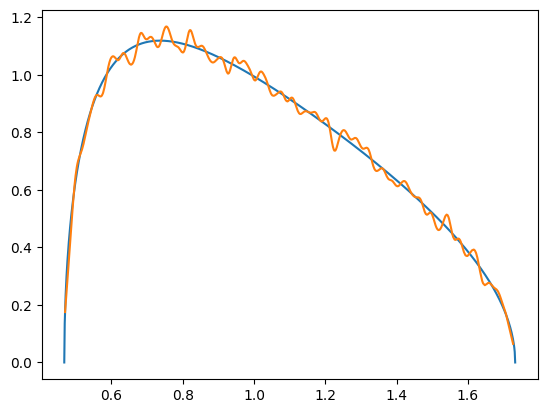

In [106]:
def mpPDF(var, q, pts):
    """
    Compute the Marcenko-Pastur probability density function (PDF).
    
    Parameters:
    - var: Variance of the underlying process (generating observations X)
    - q: Ratio T/N where X is of size TxN (T observations, N features)
    - pts: Number of points to evaluate the PDF at
    
    Returns:
    - pandas Series containing the PDF values, indexed by eigenvalues
    
    Notes:
    - The MP law describes the asymptotic distribution of eigenvalues of random correlation matrices
    - For q < 1, the distribution has a point mass at 0 with weight 1-q
    """
    # Calculate minimum and maximum eigenvalues
    eMin = var * (1 - (1./q)**0.5)**2
    eMax = var * (1 + (1./q)**0.5)**2
    
    # Generate eigenvalues (lambda) between eMin and eMax
    eVal = np.linspace(eMin, eMax, pts).flatten()
    
    # Compute Marcenko-Pastur PDF
    pdf = q/(2*np.pi*var*eVal) * ((eMax-eVal)*(eVal-eMin))**0.5
    pdf = pd.Series(pdf, index=eVal)
    
    return pdf

#---------------------------------------------------------------------------------------------------------

def getPCA(matrix, sort_descending=True):
    """
    Compute eigenvalues and eigenvectors from a Hermitian matrix (typically a correlation matrix).
    
    Parameters:
    - matrix: Input Hermitian matrix (symmetric if real-valued)
    - sort_descending: Whether to sort eigenvalues in descending order (default: True)
    
    Returns:
    - eVal: Diagonal matrix of eigenvalues (sorted if sort_descending=True)
    - eVec: Matrix of corresponding eigenvectors (sorted accordingly)
    
    Notes:
    - Uses np.linalg.eigh which is specialized for Hermitian matrices
    - When matrix is a correlation matrix, eigenvalues represent explained variance
    - Output eigenvectors are normalized to unit length
    """
    # Compute eigenvalues and eigenvectors
    eVal, eVec = np.linalg.eigh(matrix)
    
    # Sort in descending order by default
    if sort_descending:
        indices = eVal.argsort()[::-1]
        eVal = eVal[indices]
        eVec = eVec[:, indices]
    
    # Create diagonal matrix of eigenvalues
    eVal = np.diagflat(eVal)
    
    return eVal, eVec

#---------------------------------------------------------------------------------------------------------

def fitKDE(obs, bWidth=.25, kernel='gaussian', x=None):
    """
    Fit Kernel Density Estimation to a series of observations.
    
    Parameters:
    - obs: Input data (1D array or 2D array-like)
    - bWidth: Bandwidth for KDE (default: 0.25)
    - kernel: Kernel type (default: 'gaussian')
    - x: Points to evaluate the KDE (if None, uses unique values from obs)
    
    Returns:
    - pandas Series with estimated PDF values indexed by x values
    """
    # Reshape if 1D array
    if len(obs.shape) == 1:
        obs = obs.reshape(-1, 1)
    
    # Fit KDE
    kde = KernelDensity(kernel=kernel, bandwidth=bWidth).fit(obs)
    
    # Set evaluation points
    if x is None:
        x = np.unique(obs).reshape(-1, 1)
    elif len(x.shape) == 1:
        x = x.reshape(-1, 1)
    
    # Get log probabilities and convert to PDF
    logProb = kde.score_samples(x)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())

    return pdf

#---------------------------------------------------------------------------------------------------------

# test how closely the MP distribution (blue line) explains the eigenvalues of a random matrix X (orange line)
x = np.random.normal(size=(10000, 1000))    #T=10000 N=1000
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=1000)
# empirical pdf
pdf1 = fitKDE(np.diag(eVal0), bWidth=0.01)
# display
pdf0.plot()
pdf1.plot()

random matrix with signal

In [107]:
def getRndCov(nCols, nFacts):
    """
    Generate a random covariance matrix by combining factor structure with idiosyncratic noise.
    
    Parameters:
    - nCols: Number of columns/dimensions (features)
    - nFacts: Number of underlying factors (must be <= nCols)
    
    Returns:
    - cov: Positive semi-definite covariance matrix (nCols × nCols)
    
    Construction:
    1. Creates low-rank factor structure: W @ W.T where W ~ N(0,1)
    2. Adds full-rank diagonal noise: diag(U[0,1]))
    """
    # Factor loadings matrix (nCols × nFacts)
    w = np.random.normal(size=(nCols, nFacts))

    # Low-rank covariance from factors
    cov = np.dot(w, w.T)

    # Add full-rank diagonal noise
    cov += np.diag(np.random.uniform(size=nCols))

    return cov

#---------------------------------------------------------------------------------------------------------

def cov2corr(cov):
    """derive the correlation matrix from a covariance matrix"""
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std, std)
    corr[corr<-1], corr[corr>1] = -1 , 1 # numerical error
    return corr

#---------------------------------------------------------------------------------------------------------

alpha, nCols, nFacts, q = .995, 1000, 100, 10
cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar=0)
cov = alpha*cov + (1-alpha)*getRndCov(nCols, nFacts)     # noise + signal
corr0 = cov2corr(cov)
eVal0, eVec0 = getPCA(corr0)

fitting the MP distribution

100
0.6768314212205152


<Axes: >

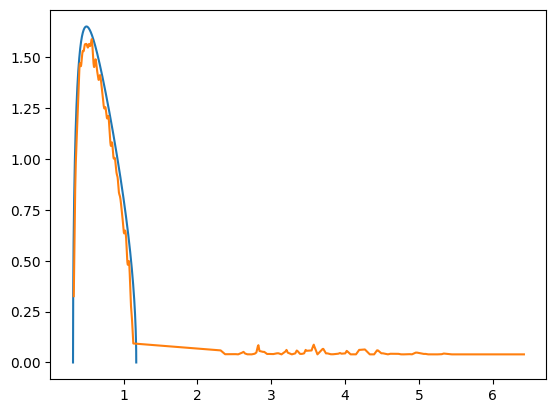

In [108]:
def errPDFs(var, eVal, q, bWidth, pts=1000):
    """
    fit error
    """
    # theorectical pdf
    pdf0 = mpPDF(var, q, pts)
    
    # empirical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values)

    # sum of the squared differences
    sse = np.sum((pdf1-pdf0)**2)

    return sse

#---------------------------------------------------------------------------------------------------------

def findMaxEval(eVal, q, bWidth):
    """
    find max random eVal by fitting MP dist
    """
    out = minimize(lambda *x: errPDFs(*x), .5, args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5),))
    if out['success']: var=out['x'][0]
    else: var=1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var

#---------------------------------------------------------------------------------------------------------
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

pdf0 = mpPDF(var0, q, 1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=0.01)

# display
print(nFacts0)  # 100 factors for fittedas we input
print(var0)     # fitted mp distribution implies sigma^2=0.677 (i.e. only about 32% of the variance can be attributed to signal)

pdf0.plot() # theorectical pdf
pdf1.plot() # empirical pdf (eigenvalues to the right of the fitted blue MP curve cannot be associated with noise, they are signal)

denoising by constant residual eigenvalue

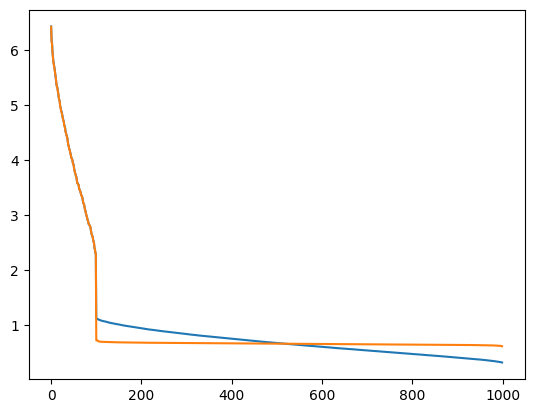

In [ ]:
def denoisedCorr(eVal, eVec, nFacts):
    """
    remove noise from corr by fixing random eigenvalues
    """
    eVal_ = np.diag(eVal).copy()
    # replace residual eigenvalues with constant average
    eVal_[nFacts:] = eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_ = np.diag(eVal_)
    cov1 = np.dot(eVec, eVal_).dot(eVec.T)
    corr1 = cov2corr(cov1)
    return corr1

#---------------------------------------------------------------------------------------------------------

corr1 = denoisedCorr(eVal0, eVec0, nFacts0)
eVal1, eVec1 = getPCA(corr1)

# display for comparison
plt.plot(np.diag(eVal0))
plt.plot(np.diag(eVal1)) 

denoising by targeted shrinkage

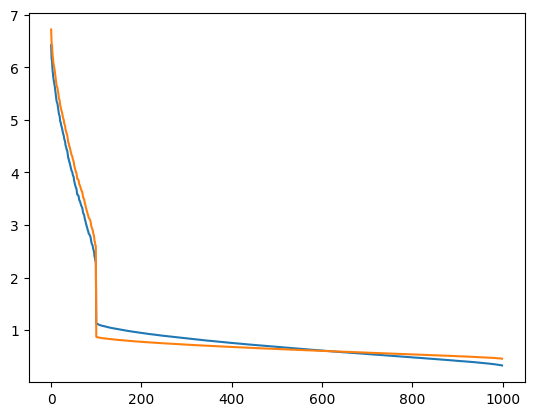

In [110]:
def denoisedCorr2(eVal, eVec, nFacts, alpha=0):
    """
    remove noise from corr through targeted shrinkage
    """
    eValL, eVecL = eVal[ :nFacts, :nFacts], eVec[:, :nFacts]
    eValR, eVecR = eVal[nFacts: ,nFacts: ], eVec[:,nFacts: ]
    corr0 = np.dot(eVecL, eValL).dot(eVecL.T)
    corr1 = np.dot(eVecR, eValR).dot(eVecR.T)
    # alpha regulates the amount of shrinkage associated with noise (alpha->0 for total shrinkage)
    corr2 = corr0 + alpha*corr1 + (1-alpha)*np.diag(np.diag(corr1))
    return corr2

#---------------------------------------------------------------------------------------------------------

corr2 = denoisedCorr2(eVal0, eVec0, nFacts0, alpha=0.5)
eVal2, eVec2 = getPCA(corr2)

# display for comparison
plt.plot(np.diag(eVal0))
plt.plot(np.diag(eVal2)) 

detoning

In [111]:
# removing market component (especially useful for correlation clustering)
# analogue to computing beta-adjusted (market-adjusted) returns in regression analysis
# the detoned corr matrix is singular (not invertible) but not a problem for clustering application
# for mean-variance optimization, can optimize on selected(non-zero) principal components and map the optimal allocatio back to original basis

experimental results - minimum variance portfolio

In [112]:
# generating a block-diagonal covariance matrix and a vector of means
# a stylized representation of a true (nonempirical) denoted correlation matrix of SP500
#       each block is associated with an economic sector

from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf

def formBlockMatrix(nBlocks, bSize, bCorr):
    block = np.ones((bSize, bSize))*bCorr
    block[range(bSize), range(bSize)] = 1
    corr = block_diag(*([block]*nBlocks))
    return corr

#---------------------------------------------------------------------------------------------------------

def corr2cov(corr, std):
    cov = corr*np.outer(std, std)
    return cov

#---------------------------------------------------------------------------------------------------------

def formTrueMatrix(nBlocks, bSize, bCorr):
    corr0 = formBlockMatrix(nBlocks, bSize, bCorr)
    corr0 = pd.DataFrame(corr0)
    cols = corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0 = corr0[cols].loc[cols].copy(deep=True)

    # variance is drawn from a uniform distribution between 5%-20%
    # mean is drawn from normal distribution
    # consistent with the notion that in efficient market all securities have same expected sharpe ratio
    std0 = np.random.uniform(0.05, 0.2, corr0.shape[0])
    cov0 = corr2cov(corr0, std0)
    mu0 = np.random.normal(std0, std0, cov0.shape[0]).reshape(-1, 1)
    return mu0, cov0

#---------------------------------------------------------------------------------------------------------

nBlocks, bSize, bCorr = 10, 50, .5  # 10 blocks of size 50 for each, off-diagonal elements with each block have a corr of 0.5
np.random.seed(0)
mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)


In [ ]:
# empirical covariance matrix

def simCovMu(mu0, cov0, nObs, shrink=False):
    """
    generate empirical(true) covariance matrix (shrinkage optional)
    """
    # draw a random matrix X (of size TxN, T=nObs)
    x = np.random.multivariate_normal(mu0.flatten(), cov0, size=nObs)
    # derive mu and cov from X
    mu1 = x.mean(axis=0).reshape(-1, 1)
    if shrink: 
        cov1 = LedoitWolf().fit(x).covariance_
    else:
        cov1 = np.cov(x, rowvar=0)
    return mu1, cov1

#---------------------------------------------------------------------------------------------------------

def deNoiseCov(cov0, q, bWidth):
    """
    denoise the empirical covariance matrix
    """
    corr0 = cov2corr(cov0)
    eVal0, eVec0 = getPCA(corr0)
    eMax, var0 = findMaxEval(np.diag(eVal0), q, bWidth)
    nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1 = denoisedCorr(eVal0, eVec0, nFacts0)
    cov1 = corr2cov(corr1, np.diag(cov0)**.5)
    return cov1

#---------------------------------------------------------------------------------------------------------

def optPort(cov, mu=None):
    """
    derive the minimum variance portfolio
    """
    inv = np.linalg.inv(cov)
    ones = np.ones(shape=(inv.shape[0], 1))
    if mu is None:
        mu = ones
    w = np.dot(inv, mu)
    w /= np.dot(ones.T, w)
    return w

#---------------------------------------------------------------------------------------------------------

# Monte Carlo experiment (on the same cov matrices with and without denoising, not shrunk)
nObs, nTrials, bWidth, shrink, minVarPortf = 1000, 1000, 0.01, False, True
w1 = pd.DataFrame(columns=range(cov0.shape[0]), index=range(nTrials), dtype=float)
w1_d = w1.copy(deep=True)
np.random.seed(0)
for i in range(nTrials):
    mu1, cov1 = simCovMu(mu0, cov0, nObs, shrink=shrink)
    if minVarPortf: 
        mu1 = None
    cov1_d = deNoiseCov(cov1, nObs*1./cov1.shape[1], bWidth)
    w1.loc[i] = optPort(cov1, mu1).flatten()
    w1_d.loc[i] = optPort(cov1_d, mu1).flatten()

# compute the true minimum variance portfolio from the true matrix
w0 = optPort(cov0, None if minVarPortf else mu0)
w0 = np.repeat(w0.T, w1.shape[0], axis=0)
# root-mean-square erros
rmsd = np.mean((w1-w0).values.flatten()**2)**.5
rmsd_d = np.mean((w1_d-w0).values.flatten()**2)**.5
print(rmsd, rmsd_d)

0.00495905524173486 0.001336992566937976


In [ ]:
# Monte Carlo experiment (on the same cov matrices with and without denoising, shrunk)
nObs, nTrials, bWidth, shrink, minVarPortf = 1000, 1000, 0.01, True, True
w1 = pd.DataFrame(columns=range(cov0.shape[0]), index=range(nTrials), dtype=float)
w1_d = w1.copy(deep=True)
np.random.seed(0)
for i in range(nTrials):
    mu1, cov1 = simCovMu(mu0, cov0, nObs, shrink=shrink)
    if minVarPortf: 
        mu1 = None
    cov1_d = deNoiseCov(cov1, nObs*1./cov1.shape[1], bWidth)
    w1.loc[i] = optPort(cov1, mu1).flatten()
    w1_d.loc[i] = optPort(cov1_d, mu1).flatten()

# compute the true minimum variance portfolio from the true matrix
w0 = optPort(cov0, None if minVarPortf else mu0)
w0 = np.repeat(w0.T, w1.shape[0], axis=0)
# root-mean-square erros
rmsd = np.mean((w1-w0).values.flatten()**2)**.5
rmsd_d = np.mean((w1_d-w0).values.flatten()**2)**.5
print(rmsd, rmsd_d)

0.003455970753593775 0.0015131226445743722


In [ ]:
# above results show denoising is much more effective than shrinkage